In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, model_selection

import time
#from matplotlib import pyplot as plt
from matplotlib import pylab as plt
from IPython import display

from Funciones import evaluar, evaluarDerivada

In [3]:
df_train = pd.read_csv(DATOS_DIR+'optdigits_train.csv')
X_train = np.array(df_train.iloc[:,:-1]).astype(float)
Y_train = np.array(df_train.iloc[:,-1])

df_test = pd.read_csv(DATOS_DIR+'optdigits_test.csv')
X_test = np.array(df_test.iloc[:,:-1]).astype(float)
Y_test = np.array(df_test.iloc[:,-1])

In [4]:
entradas = X_train.shape[1]
ocultas = 15

#-- la red tendrá una salida para cada dígito
salidas = 10
print("entradas = %d ; salidas = %d" % (entradas, salidas))

Y_trainB = np.zeros((len(Y_train), salidas))
for o in range(len(Y_train)):
    Y_trainB[o, Y_train[o]]=1
    
Y_testB = np.zeros((len(Y_test), salidas))
for o in range(len(Y_test)):
    Y_testB[o, Y_test[o]]=1

entradas = 64 ; salidas = 10


In [5]:
normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores entre 0 y 1
    min_max_scaler = preprocessing.StandardScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    

In [6]:
W1 = np.random.uniform(-0.5,0.5,[ocultas, entradas])
b1 = np.random.uniform(-0.5,0.5, [ocultas,1])
W2 = np.random.uniform(-0.5,0.5,[salidas, ocultas])
b2 = np.random.uniform(-0.5,0.5, [salidas,1])

In [7]:
FunH = 'sigmoid'
FunO = 'sigmoid'

if (FunO=='tanh'):
    Y_trainB = 2*Y_trainB -1
    Y_testB  = 2*Y_testB - 1

In [8]:
nFilas = X_train.shape[0]

alfa = 0.1
CotaError = 1.0e-4
MAX_ITERA = 400
ite = 0
errorAnt = 0
AVGError = 1
errores = []

print("Inicio ...")
tIni = time.time()

while ( abs(AVGError-errorAnt) > CotaError ) and ( ite < MAX_ITERA ):
    errorAnt = AVGError
    AVGError = 0
    for e in range(nFilas):  #para cada ejemplo

        xi = X_train[e:e+1, :]     # ejemplo a ingresar a la red
        yi = Y_trainB[e:e+1, :]     # salida esperada para el ejemplo seleccionado
        
        # propagar el ejemplo hacia adelante
        netasH = W1 @ xi.T + b1
        salidasH = evaluar(FunH, netasH)
        netasO = W2 @ salidasH + b2
        salidasO = evaluar(FunO, netasO)

        # calcular los errores en ambas capas        
        ErrorSalida = yi.T-salidasO
        
        deltaO = ErrorSalida * evaluarDerivada(FunO,salidasO)
        deltaH = evaluarDerivada(FunH,salidasH)*(W2.T @ deltaO)

        # corregir todos los pesos      
        W1 = W1 + alfa * deltaH @ xi 
        b1 = b1 + alfa * deltaH 
        W2 = W2 + alfa * deltaO @ salidasH.T 
        b2 = b2 + alfa * deltaO 

        AVGError = AVGError + np.mean(ErrorSalida**2)
    
    AVGError = AVGError / nFilas
    errores.append(AVGError)
    
    ite = ite + 1
   
tFin = time.time()
print("duración %.7f seg" % (tFin- tIni))


Inicio ...
duración 4.2795477 seg


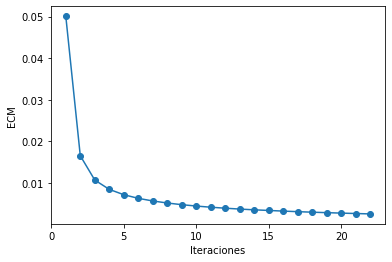

In [9]:
plt.plot(range(1, len(errores) + 1), errores, marker='o')
plt.xlabel('Iteraciones')
plt.ylabel('ECM')
plt.show()

In [10]:
# Respuesta de la red para los datos de ENTRENAMIENTO ---
NetasH = W1 @ X_train.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)
np.round(SalidasO[:, :5],3)

array([[0.98 , 0.99 , 0.002, 0.   , 0.057],
       [0.   , 0.   , 0.   , 0.005, 0.001],
       [0.005, 0.009, 0.002, 0.   , 0.001],
       [0.   , 0.   , 0.001, 0.   , 0.   ],
       [0.004, 0.005, 0.002, 0.609, 0.012],
       [0.008, 0.004, 0.   , 0.002, 0.014],
       [0.005, 0.005, 0.   , 0.   , 0.943],
       [0.004, 0.006, 0.996, 0.005, 0.   ],
       [0.001, 0.001, 0.   , 0.008, 0.02 ],
       [0.004, 0.002, 0.   , 0.116, 0.   ]])

In [11]:
Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_train : %.3f" % metrics.accuracy_score(Y_train,Y_pred))

% aciertos X_train : 0.992


In [12]:
report = metrics.classification_report(Y_train,Y_pred)
print("Confusion matrix Training:\n%s" % report) 

Confusion matrix Training:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       376
           1       0.99      0.99      0.99       389
           2       1.00      1.00      1.00       380
           3       1.00      0.99      0.99       389
           4       0.98      0.99      0.99       387
           5       0.99      0.99      0.99       376
           6       0.99      1.00      0.99       377
           7       0.99      1.00      1.00       387
           8       1.00      0.98      0.99       380
           9       0.98      0.99      0.98       382

    accuracy                           0.99      3823
   macro avg       0.99      0.99      0.99      3823
weighted avg       0.99      0.99      0.99      3823



In [13]:
MM = metrics.confusion_matrix(Y_train,Y_pred)
print("Confusion matrix:\n%s" % MM)

Confusion matrix:
[[375   0   0   0   1   0   0   0   0   0]
 [  0 386   0   0   0   0   0   1   0   2]
 [  0   0 380   0   0   0   0   0   0   0]
 [  0   0   0 384   0   3   0   1   0   1]
 [  1   0   0   0 383   0   3   0   0   0]
 [  1   0   0   0   0 371   0   0   0   4]
 [  0   1   0   0   0   0 376   0   0   0]
 [  0   0   0   0   0   0   0 387   0   0]
 [  0   3   0   0   2   1   0   0 374   0]
 [  1   1   0   0   3   0   0   0   0 377]]


In [14]:
# -- TESTING ---
NetasH = W1 @ X_test.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)

Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_test : %.3f\n" % metrics.accuracy_score(Y_test,Y_pred))

report = metrics.classification_report(Y_test, Y_pred)
print("Confusion matrix Test:\n%s" % report) 

MM = metrics.confusion_matrix(Y_test, Y_pred)
print("Confusion matrix:\n%s" % MM)

% aciertos X_test : 0.955

Confusion matrix Test:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       178
           1       0.92      0.95      0.93       182
           2       0.95      0.95      0.95       177
           3       0.99      0.93      0.96       183
           4       0.96      0.98      0.97       181
           5       0.92      0.97      0.95       182
           6       0.98      0.98      0.98       181
           7       0.99      0.93      0.96       179
           8       0.95      0.91      0.93       174
           9       0.91      0.97      0.94       180

    accuracy                           0.96      1797
   macro avg       0.96      0.96      0.96      1797
weighted avg       0.96      0.96      0.96      1797

Confusion matrix:
[[174   0   0   0   1   2   1   0   0   0]
 [  0 173   1   0   0   0   0   0   3   5]
 [  0   6 168   0   0   0   1   1   1   0]
 [  0   0   6 170   0   3   0   1   0   3]
 